### bd CPS graph basic labor market indicators

bd_CPS_grapher.ipynb

October 1, 2018

@bd_econ

Requires: `cpsYYYY.ft`.

____

Notes:

Several [open issues](https://github.com/bdecon/econ_data/issues) on GitHub. This code needs to do four things: 1) read and aggregate CPS data as instructed (one month, three months, one year, two years); 2) Apply some pre-specified calculations, such as the employment-to-population ratio, unemployment rate, usual earnings at various percentiles, etc.; 3) apply adjustments after the fact, such as moving average, or adjustment for inflation; and 4) allow for collecting data on multiple groups during each read cycle. 

Once the collected data are prepared, use matplotlib to generate nice-looking line plots. 



The [categorization](https://www.frbatlanta.org/chcs/human-capital-currents/2015/0612-measuring-labor-market-status-using-basic-data.aspx) of those not in the labor force is provided by the Federal Reserve Bank of Atlanta. 

In [1]:
# Import packages, adjust settings and set file path
import os
import pandas as pd
import numpy as np

os.chdir('/home/brian/Documents/CPS/data/clean/')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)
plt.rcParams.update({'axes.titlesize': 'x-large'})

# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]

In [2]:
# Define functions to collect and graph data
def bd_cps_data(query_str, calc_type, smoothing='12sma'):
    """Calculate various labor market indicators from
       bd CPS annual feather files."""
    
    filter_cols = ['PREMPNOT', 'PWSSWGT', 'HRMONTH']
    
    # Employment-to-population ratio
    if calc_type == 'epop':
        keep_cols = ['EMP', 'POP', 'HRMONTH']
        component_vars = {'EMP': lambda x: np.where(x['PREMPNOT']==1,  x['PWSSWGT'], 0),
                          'POP': lambda x: np.where(x['PREMPNOT'].isin([1, 2, 3, 4]), 
                                                    x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['EMP'] / x['POP']) * 100

    # Unemployment rate
    if calc_type == 'unrate':
        keep_cols = ['UNEMP', 'LF', 'HRMONTH']
        component_vars = {'UNEMP': lambda x: np.where(x['PREMPNOT']==2, x['PWSSWGT'], 0),
                          'LF': lambda x: np.where(x['PREMPNOT'].isin([1, 2]), x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['UNEMP'] / x['LF']) * 100
    
    # Labor force participation rate
    if calc_type == 'lfpr':
        keep_cols = ['LF', 'POP', 'HRMONTH']
        component_vars = {'LF': lambda x: np.where(x['PREMPNOT'].isin([1, 2]), x['PWSSWGT'], 0),
                          'POP': lambda x: np.where(x['PREMPNOT'].isin([1, 2, 3, 4]), 
                                                    x['PWSSWGT'], 0)}
        calc_var = lambda x: (x['LF'] / x['POP']) * 100
        
    # Labor union membership (or similar, such as employee association)
    if calc_type == 'union':
        filter_cols = ['PEERNLAB', 'PWORWGT', 'HRMONTH']
        keep_cols = ['UNION', 'TOT', 'HRMONTH']
        component_vars = {'TOT': lambda x: np.where(x['PEERNLAB'].isin([1, 2]), x['PWORWGT'], 0),
                          'UNION': lambda x: np.where(x['PEERNLAB']==1, x['PWORWGT'], 0)}
        calc_var = lambda x: (x['UNION'] / x['TOT']) * 100
    
    data = (pd.concat(
        [(pd.read_feather(f'cps{year}.ft', nthreads=3)
            .query(query_str)
            .filter(items = filter_cols)
            .assign(**component_vars)
            .filter(items = keep_cols)
            .groupby('HRMONTH').sum()
            .pipe(cps_datetime, year)
            .set_index('DATE')) 
        for year in year_range])
            .rolling(12).sum().dropna()
            .assign(FINAL = calc_var)
           )['FINAL']
    return data
    
def cps_datetime(df, year):
    """Return DATE '1994-01-01' from HRMONTH and year"""
    df['DATE'] = [pd.to_datetime(f'{year}-{month}-01') 
                  for month in df.index]
    return df

year_range = range(1994, 2019)    
    

def labor_mkt_grapher(title, data, color):
    """Graph time series data from 1994 to present, with recession bars
       and the most recent monthly data point labeled and annotated."""
    spcr, spcr2 = (data.max() - data.min()) / 26, (data.max() - data.min()) / 40
    ax = data.plot(figsize=(8, 4), color=color)
    ax = plt.title(title, loc='left')
    ax = plt.scatter([data.index[-1]], [data[-1]], color=color, s=25)
    for i, v in rec_dt:
        ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.2)
    ax = plt.annotate(f'   {data[-1]: .1f}%', (data.index[-1], data[-1]-spcr2))
    ax = plt.xlabel('Source: Current Population Survey microdata, 12-month moving average', ha='left', x=0)
    ax = plt.annotate(f'  {data.index[-1]:%b %Y}', (data.index[-1], data[-1]+spcr), 
                      fontweight='bold')    

In [29]:
# Example query string used to filter CPS
filters = 'PRTAGE >= 25 and PRTAGE <= 54 and PESEX == 2'
group = 'women age 25-54'
#filters = 'STATE=="NY"'
#filters = 'WBHAO=="Black" and PRTAGE < 25 and PESEX == 1'

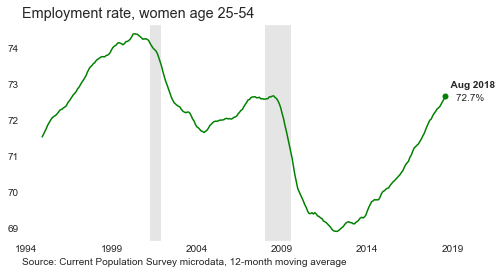

In [30]:
# Employment Rate
calc_type = 'epop'
title = f'Employment rate, {group}'
data = bd_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')

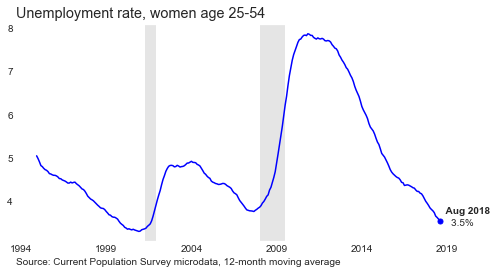

In [31]:
# Unemployment Rate
calc_type = 'unrate'
title = f'Unemployment rate, {group}'
data = bd_cps_data(filters, calc_type) 
labor_mkt_grapher(title, data, 'blue')

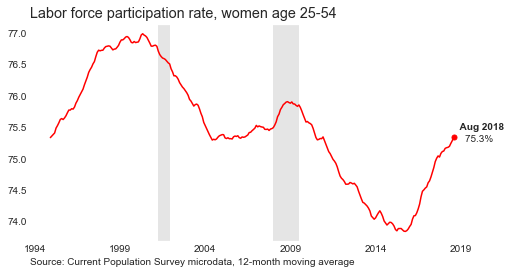

In [32]:
# Labor force participation Rate
calc_type = 'lfpr'
title = f'Labor force participation rate, {group}'
data = bd_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'red')

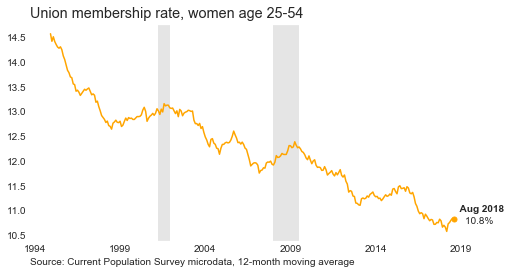

In [33]:
# Union membership rate (uses 1/4 sample)
calc_type = 'union'
title = f'Union membership rate, {group}'
data = bd_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'orange')